<a href="https://colab.research.google.com/github/casangi/ngcasa/blob/master/docs/prototypes/imaging_weights_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imaging Weights

This notebook will demonstrate how to create images with different imaging weighting schemes (natural, uniform, briggs) and how to make use of the ```storage_parms``` to append images.

For this demonstration data from the ALMA First Look at Imaging CASAguide (https://casaguides.nrao.edu/index.php/First_Look_at_Imaging) will be used. The measurement set has been converted to vis.zarr (using convert_ms in cngi.conversion) and uploaded to the WAS S3 cloud.  This walkthrough is designed to be run in a Jupyter notebook on Google Colaboratory. To open the notebook in colab, go [here](https://colab.research.google.com/github/casangi/ngcasa/blob/master/docs/prototypes/imaging_weights_example.ipynb).



## Installation

- S3Fs is a pythonic file interface to AWS S3 cloud storage (all the needed data is stored here).
- ngcasa is the prototype for the next generation of CASA software.
- cngi-prototype casa next generation infrastructure.
- graphviz is required for visualizing the task graph.



In [1]:
import os
os.system("pip install s3fs")
os.system("pip install ngcasa==0.0.9")
os.system("pip install cngi-prototype==0.0.53")
os.system("pip install graphviz")
print("complete")

complete


## Load Data from AWS S3 Cloud


In [3]:
import s3fs
import xarray as xr

# Initialize the S3 "file system"
s3 = s3fs.S3FileSystem(anon=True, requester_pays=False)

# Specify AWS S3 paths
bucket = "cngi-prototype-test-data/"
s3_path = bucket+"test_data/"

if s3.isdir(s3_path): # it's working  
    print("AWS S3 Path found")

s3_vis = s3_path+"sis14_twhya_field_5_lsrk_pol_xx.vis.zarr/0"
s3_metadata = s3_path+"sis14_twhya_field_5_lsrk_pol_xx.vis.zarr/global"

# Convert object stores to our desired MutableMapping interface
store_vis = s3fs.S3Map(root=s3_vis, s3=s3, check=False)
store_global = s3fs.S3Map(root=s3_metadata, s3=s3, check=False)

# Read zarr files
vis_dataset = xr.open_zarr(store=store_vis, consolidated=True)

#Saving a local copy of the dataset
local_store_file = "sis14_twhya_field_5_lsrk_pol_xx.vis.zarr/0"
xr.Dataset.to_zarr(vis_dataset,store=local_store_file, mode='w',consolidated=True)


AWS S3 Path found


## Load Dataset

For an explanation of how the vis.zarr file was created and the chunking go to the [continuum image example](https://ngcasa.readthedocs.io/en/latest/prototypes/continuum_imaging_example.html).

In [4]:
import xarray as xr
local_store = "sis14_twhya_field_5_lsrk_pol_xx.vis.zarr/0"

vis_dataset = xr.open_zarr(store=local_store,chunks={'chan':192})

print(vis_dataset)

<xarray.Dataset>
Dimensions:        (baseline: 210, chan: 384, pair: 2, pol: 1, receptor: 2, spw: 1, time: 270, uvw_index: 3)
Coordinates:
    antennas       (baseline, pair) int32 dask.array<chunksize=(210, 2), meta=np.ndarray>
  * baseline       (baseline) int64 0 1 2 3 4 5 6 ... 204 205 206 207 208 209
  * chan           (chan) float64 3.725e+11 3.725e+11 ... 3.728e+11 3.728e+11
    chan_width     (chan) float64 dask.array<chunksize=(192,), meta=np.ndarray>
    corr_product   (receptor, pol) int32 dask.array<chunksize=(2, 1), meta=np.ndarray>
    effective_bw   (chan) float64 dask.array<chunksize=(192,), meta=np.ndarray>
    field          (time) <U6 dask.array<chunksize=(270,), meta=np.ndarray>
    interval       (time) float64 dask.array<chunksize=(270,), meta=np.ndarray>
    observation    (time) <U22 dask.array<chunksize=(270,), meta=np.ndarray>
  * pol            (pol) int32 9
    processor      (time) <U14 dask.array<chunksize=(270,), meta=np.ndarray>
    resolution     (chan)

## Storage Parameters
All of the ngcasa.synthesis.imaging functions requires a dict called ```storage_parms```. This dict has the following parameters:
- storage_parms['to_disk'] (bool, default = False) If True the dask graph is executed and saved to disk in the zarr format.
- storage_parms['append'] (bool, default = False) If storage_parms[‘to_disk’] is True only the dask graph associated with the function is executed and the resulting data variables are saved to an existing zarr file on disk. Note that graphs of unrelated data to this function will not be executed or saved.
- storage_parms['outfile'] (str) The zarr file to create or append to.
- storage_parms['compressor'] (numcodecs.blosc.Blosc,default=Blosc(cname='zstd', clevel=2, shuffle=0)) The compression algorithm to use. Available compression algorithms can be found [here](https://numcodecs.readthedocs.io/en/stable/blosc.html).
    
    

In [0]:
storage_parms = {}
storage_parms['to_disk'] = True  #bool, default: False
storage_parms['append'] = True   #bool, default: False
storage_parms['outfile'] = "sis14_twhya_field_5_lsrk_pol_xx.vis.zarr/0" #str, No default, #storage_parms['outfile'] is same as openfile since data variables will be appended to dataset.
#storage_parms['compressor'], #Blosc, Default: Blosc(cname='zstd', clevel=2, shuffle=0)

## Make Imaging Weights

The ```storage_parms['append']``` is set to True which will append each of the three different imaging weighting schemes to sis14_twhya_field_5_lsrk_pol_xx.vis.zarr/0. The name of each imaging weighting can be specified using the ```imaging_weight_parms['imaging_weight_name']``` parameter.

[make_imaging_weight documentation](https://ngcasa.readthedocs.io/en/latest/_api/api/ngcasa.imaging.make_imaging_weight.html#ngcasa.imaging.make_imaging_weight)


In [6]:
from ngcasa.imaging import make_imaging_weight

imaging_weight_parms = {}
imaging_weight_parms['robust'] = 0.6 #number, default:0.5, acceptable values [-2,2]
imaging_weight_parms['imsize'] = [200,200]   
imaging_weight_parms['cell']  = [0.04,0.04]  
imaging_weight_parms['chan_mode'] = 'continuum'

imaging_weight_parms['weighting'] = 'natural'
imaging_weight_parms['imaging_weight_name'] = 'IMAGING_WEIGHT_NAT'
make_imaging_weight(vis_dataset, imaging_weight_parms, storage_parms)

imaging_weight_parms['weighting'] = 'uniform'
imaging_weight_parms['imaging_weight_name'] = 'IMAGING_WEIGHT_UNI'
make_imaging_weight(vis_dataset, imaging_weight_parms, storage_parms)

imaging_weight_parms['weighting'] = 'briggs'
imaging_weight_parms['imaging_weight_name'] = 'IMAGING_WEIGHT_BRG'
vis_dataset=make_imaging_weight(vis_dataset, imaging_weight_parms, storage_parms)

#The print statement of the vis_dataset shows that the different imaging weighting schemes have been added.
print(vis_dataset)

######################### Start make_imaging_weights #########################
Setting default data_name  to  DATA
Setting default uvw_name  to  UVW
Setting default compressor  to  Blosc(cname='zstd', clevel=2, shuffle=NOSHUFFLE, blocksize=0)
Setting default chunks_on_disk  to  {}
Setting default chunks_return  to  {}
Setting default graph_name  to  make_imaging_weights
WEIGHT data variable found, will use WEIGHT to calculate  IMAGING_WEIGHT_NAT
Atempting to add  IMAGING_WEIGHT_NAT  to  sis14_twhya_field_5_lsrk_pol_xx.vis.zarr/0
ERROR : Could not append  IMAGING_WEIGHT_NAT to sis14_twhya_field_5_lsrk_pol_xx.vis.zarr/0
##################### Created graph for make_imaging_weights #####################
######################### Start make_imaging_weights #########################
Setting default data_name  to  DATA
Setting default uvw_name  to  UVW
Setting default compressor  to  Blosc(cname='zstd', clevel=2, shuffle=NOSHUFFLE, blocksize=0)
Setting default chunks_on_disk  to  {}
Setting d

## Make PSF

For the first dirty image ```storage_parms['append']``` is set to False so that a new img.zarr folder is created. The PSF and dirty images that follow can be appended.

[make_psf documentation](https://ngcasa.readthedocs.io/en/latest/_api/api/ngcasa.imaging.make_psf.html)

######################### Start make_psf #########################
Setting default data_name  to  DATA
Setting default uvw_name  to  UVW
Setting default compressor  to  Blosc(cname='zstd', clevel=2, shuffle=NOSHUFFLE, blocksize=0)
Setting default chunks_on_disk  to  {}
Setting default chunks_return  to  {}
Setting default graph_name  to  make_psf
Saving dataset to  twhya_standard_gridder_lsrk_mfs.img.zarr
Time to store and execute graph  make_psf 4.923885822296143
##################### Created new dataset with make_psf #####################
######################### Start make_psf #########################
Setting default data_name  to  DATA
Setting default uvw_name  to  UVW
Setting default compressor  to  Blosc(cname='zstd', clevel=2, shuffle=NOSHUFFLE, blocksize=0)
Setting default chunks_on_disk  to  {}
Setting default chunks_return  to  {}
Setting default graph_name  to  make_psf
Atempting to add  ['PSF_UNI', 'SUM_WEIGHT_UNI_PSF']  to  twhya_standard_gridder_lsrk_mfs.img.zarr
('d0',

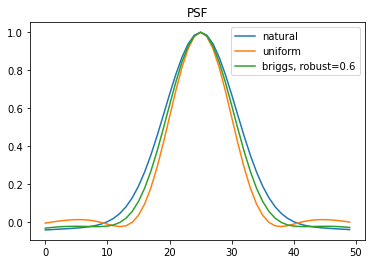

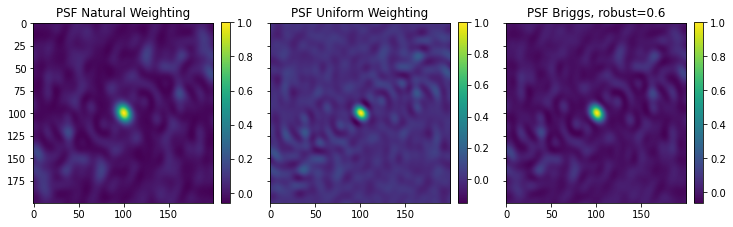

In [7]:
from ngcasa.imaging import make_psf
import matplotlib.pylab as plt
import xarray

grid_parms = {}
grid_parms['chan_mode'] = 'continuum'
grid_parms['imsize'] =  [200,200]
grid_parms['cell'] = [0.04, 0.04]
grid_parms['oversampling'] = 100
grid_parms['support'] = 7
grid_parms['fft_padding'] =  1.2


storage_parms['append'] = False #'append' needs to be changed to false since an img.zarr file does not exist yet.
storage_parms['outfile'] = 'twhya_standard_gridder_lsrk_mfs.img.zarr' #Change outfile name to image file.

grid_parms['imaging_weight_name'] = 'IMAGING_WEIGHT_NAT'
grid_parms['image_name'] = 'PSF_NAT'
grid_parms['sum_weight_name'] = 'SUM_WEIGHT_NAT_PSF'
img_dataset = make_psf(vis_dataset,grid_parms,storage_parms)

storage_parms['append'] = True #Since storage_parms['outfile'] has been created we can now append the other psf files
grid_parms['imaging_weight_name'] = 'IMAGING_WEIGHT_UNI'
grid_parms['image_name'] = 'PSF_UNI'
grid_parms['sum_weight_name'] = 'SUM_WEIGHT_UNI_PSF'
img_dataset = make_psf(vis_dataset,grid_parms,storage_parms)

grid_parms['imaging_weight_name'] = 'IMAGING_WEIGHT_BRG'
grid_parms['image_name'] = 'PSF_BRG'
grid_parms['sum_weight_name'] = 'SUM_WEIGHT_BRG_PSF'
img_dataset = make_psf(vis_dataset,grid_parms,storage_parms)

## Plot PSF images
plt.figure()
plt.plot(img_dataset.PSF_NAT[100,75:125,0,0],label='natural')
plt.plot(img_dataset.PSF_UNI[100,75:125,0,0],label='uniform')
plt.plot(img_dataset.PSF_BRG[100,75:125,0,0],label='briggs, robust='+str(imaging_weight_parms['robust']))
plt.legend()
plt.title('PSF')
plt.show()


fig0, ax0 = plt.subplots(1, 3, sharey=True,figsize=(12, 5))
im0 = ax0[0].imshow(img_dataset.PSF_NAT[:,:,0,0])
im1 = ax0[1].imshow(img_dataset.PSF_UNI[:,:,0,0])
im2 = ax0[2].imshow(img_dataset.PSF_BRG[:,:,0,0])
ax0[0].title.set_text('PSF Natural Weighting')
ax0[1].title.set_text('PSF Uniform Weighting')
ax0[2].title.set_text('PSF Briggs, robust='+str(imaging_weight_parms['robust']))
fig0.colorbar(im0, ax=ax0[0], fraction=0.046, pad=0.04)
fig0.colorbar(im1, ax=ax0[1], fraction=0.046, pad=0.04)
fig0.colorbar(im2, ax=ax0[2], fraction=0.046, pad=0.04)
plt.show()

## Make Dirty Images

[make_image documentation](https://ngcasa.readthedocs.io/en/latest/_api/api/ngcasa.imaging.make_image.html)

######################### Start make_dirty_image #########################
Setting default data_name  to  DATA
Setting default uvw_name  to  UVW
Setting default compressor  to  Blosc(cname='zstd', clevel=2, shuffle=NOSHUFFLE, blocksize=0)
Setting default chunks_on_disk  to  {}
Setting default chunks_return  to  {}
Setting default graph_name  to  make_dirty_image
Atempting to add  ['DIRTY_IMAGE_NAT', 'SUM_WEIGHT_NAT']  to  twhya_standard_gridder_lsrk_mfs.img.zarr
('d0', 'd1', 'chan', 'pol')
Time to append and execute graph  make_dirty_image 5.215315818786621
##################### Finished appending dirty image #####################
######################### Start make_dirty_image #########################
Setting default data_name  to  DATA
Setting default uvw_name  to  UVW
Setting default compressor  to  Blosc(cname='zstd', clevel=2, shuffle=NOSHUFFLE, blocksize=0)
Setting default chunks_on_disk  to  {}
Setting default chunks_return  to  {}
Setting default graph_name  to  make_dirty_im

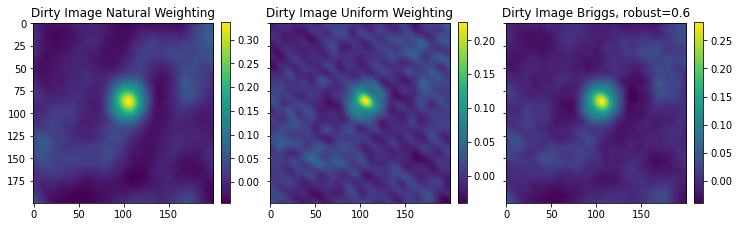

In [9]:
from ngcasa.imaging import make_image

grid_parms['imaging_weight_name'] = 'IMAGING_WEIGHT_NAT'
grid_parms['image_name'] = 'DIRTY_IMAGE_NAT'
grid_parms['sum_weight_name'] = 'SUM_WEIGHT_NAT'
img_dataset = make_image(vis_dataset,grid_parms,storage_parms)

grid_parms['imaging_weight_name'] = 'IMAGING_WEIGHT_UNI'
grid_parms['image_name'] = 'DIRTY_IMAGE_UNI'
grid_parms['sum_weight_name'] = 'SUM_WEIGHT_UNI'
img_dataset = make_image(vis_dataset,grid_parms,storage_parms)

grid_parms['imaging_weight_name'] = 'IMAGING_WEIGHT_BRG'
grid_parms['image_name'] = 'DIRTY_IMAGE_BRG'
grid_parms['sum_weight_name'] = 'SUM_WEIGHT_BRG'
img_dataset = make_image(vis_dataset,grid_parms,storage_parms)

fig0, ax0 = plt.subplots(1, 3, sharey=True,figsize=(12, 5))
im0 = ax0[0].imshow(img_dataset.DIRTY_IMAGE_NAT[:,:,0,0])
im1 = ax0[1].imshow(img_dataset.DIRTY_IMAGE_UNI[:,:,0,0])
im2 = ax0[2].imshow(img_dataset.DIRTY_IMAGE_BRG[:,:,0,0])
ax0[0].title.set_text('Dirty Image Natural Weighting')
ax0[1].title.set_text('Dirty Image Uniform Weighting')
ax0[2].title.set_text('Dirty Image Briggs, robust='+str(imaging_weight_parms['robust']))
fig0.colorbar(im0, ax=ax0[0], fraction=0.046, pad=0.04)
fig0.colorbar(im1, ax=ax0[1], fraction=0.046, pad=0.04)
fig0.colorbar(im2, ax=ax0[2], fraction=0.046, pad=0.04)
plt.show()

In [0]:
print(xr.open_zarr('twhya_standard_gridder_lsrk_mfs.img.zarr'))

<xarray.Dataset>
Dimensions:             (chan: 1, d0: 200, d1: 200, pol: 1)
Coordinates:
  * chan                (chan) float64 3.726e+11
  * d0                  (d0) int64 0 1 2 3 4 5 6 ... 193 194 195 196 197 198 199
  * d1                  (d1) int64 0 1 2 3 4 5 6 ... 193 194 195 196 197 198 199
  * pol                 (pol) int64 0
Data variables:
    DIRTY_IMAGE_BRG     (d0, d1, chan, pol) float64 dask.array<chunksize=(200, 200, 1, 1), meta=np.ndarray>
    DIRTY_IMAGE_NAT     (d0, d1, chan, pol) float64 dask.array<chunksize=(200, 200, 1, 1), meta=np.ndarray>
    DIRTY_IMAGE_UNI     (d0, d1, chan, pol) float64 dask.array<chunksize=(200, 200, 1, 1), meta=np.ndarray>
    PSF_BRG             (d0, d1, chan, pol) float64 dask.array<chunksize=(200, 200, 1, 1), meta=np.ndarray>
    PSF_NAT             (d0, d1, chan, pol) float64 dask.array<chunksize=(200, 200, 1, 1), meta=np.ndarray>
    PSF_UNI             (d0, d1, chan, pol) float64 dask.array<chunksize=(200, 200, 1, 1), meta=np.ndarra

## Execute this Notebook in Colab


https://colab.research.google.com/github/casangi/ngcasa/blob/master/docs/prototypes/imaging_weights_example.ipynb